# This is an implementation of the iLPD method

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
np.random.seed(42)
import torch
from torch import nn
import torch.optim
import tensorboardX
import memcnn
import time

import odl
from odl.contrib import fom
from odl.contrib import torch as odl_torch

from generator_downsampled_120ang import DataLoader
from utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

name = 'models/invertible_walnuts'

### Load the data

In [2]:
loader = DataLoader()

# the first walnut is used for validation, ind=1
# the second for testing, rest is for training
x_val, y_val, geometry_val = loader.generate_data(mode="val")
val_images = torch.from_numpy(x_val).type(dtype)
val_data = torch.from_numpy(y_val).type(dtype)

# define the Ray Transform operator
space_val = loader.odl_space()
operator_val = odl.tomo.RayTransform(space_val, geometry_val, impl='astra_cuda') 

# transform the operator and it's adjoint into pytorch modules
pt_op_val = odl_torch.OperatorModule(operator_val).type(dtype)
pt_op_adj_val = odl_torch.OperatorModule(operator_val.adjoint).type(dtype)

# Compute the operator norm. After each application of the operator, 
# divide the result by it's norm for numerical stability.
# Since the norm is almost the same for different walnuts, 
# it is enough to compute it for once.
opnorm = 51.5593061617 # operator_val.norm(estimate=True)
print("Norm of the operator:", opnorm) 

Norm of the operator: 51.5593061617


## Definition of the iLPD architecture

In [3]:
n_data = 1 # batch size
n_iter = 20 # number of unrolled iterations
# number of primal and dual memory channels
n_primal = 1 
n_dual = 1
n_filters = 32 # in a convolutional layer


class IterationPrimal(nn.Module):
    def __init__(self):
        super().__init__()
        self.filters = n_filters
        # The adjoint operator is implemented as a parameter 
        # for techical reason related to memcnn.
        # However, it should be updated as if was an input variable.
        self.op_adj = None

        self.primalblock = nn.Sequential(
            nn.Conv3d(n_primal, self.filters, 3, padding=1),
            nn.PReLU(num_parameters=self.filters, init=0.0),
            nn.Conv3d(self.filters, self.filters, 3, padding=1),
            nn.PReLU(num_parameters=self.filters, init=0.0),
            nn.Conv3d(self.filters, n_primal, 3, padding=1))
            

    def forward(self, primal, dual):
        inp = self.op_adj(dual) / opnorm
        primal = primal + self.primalblock(inp)
        return primal, dual.clone()
    
    def inverse(self, primal, dual):
        inp = self.op_adj(dual) / opnorm
        primal = primal - self.primalblock(inp)
        return primal, dual.clone()
    
class IterationDual(nn.Module):
    def __init__(self):
        super().__init__()
        self.filters = n_filters
        # The operator and input data are implemented as parameters 
        # for techical reason related to memcnn.
        # However, they should be updated as if they were input variables.
        self.op = None
        self.y = None
        
        self.dualblock = nn.Sequential(
            nn.Conv3d(n_dual + 1, self.filters, 3, padding=1),
            nn.PReLU(num_parameters=self.filters, init=0.0),
            nn.Conv3d(self.filters, self.filters, 3, padding=1),
            nn.PReLU(num_parameters=self.filters, init=0.0),
            nn.Conv3d(self.filters, n_dual, 3, padding=1))
            
    def forward(self, primal, dual):
        evalop = self.op(primal) / opnorm
        inp = torch.cat([evalop, self.y / opnorm ], dim=1)
        dual = dual + self.dualblock(inp)
        return primal.clone(), dual
    
    
    def inverse(self, primal, dual):
        evalop = self.op(primal) / opnorm
        inp = torch.cat([evalop, self.y / opnorm ], dim=1)
        dual = dual - self.dualblock(inp)
        return primal.clone(), dual
    
class IterativeNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = torch.nn.MSELoss()
        
        for i in range(n_iter):
            iteration_p = IterationPrimal()
            iteration_d = IterationDual()
            inv_iteration_p = memcnn.InvertibleModuleWrapper(fn=iteration_p, keep_input=False, keep_input_inverse=False)
            inv_iteration_d = memcnn.InvertibleModuleWrapper(fn=iteration_d, keep_input=False, keep_input_inverse=False)
            setattr(self, 'iteration_p_{}'.format(i), inv_iteration_p)
            setattr(self, 'iteration_d_{}'.format(i), inv_iteration_d)

    def forward(self, y, true, op, op_adj):
        im_shape = true.shape[2:]
        data_shape = y.shape[2:]
        primal = torch.zeros((n_data, n_primal) + im_shape).type(dtype)
        dual = torch.zeros((n_data, n_dual) + data_shape).type(dtype)
        
        for i in range(n_iter):
            iteration_p = getattr(self, 'iteration_p_{}'.format(i))
            iteration_d = getattr(self, 'iteration_d_{}'.format(i))
            iteration_d._fn.op = op
            iteration_d._fn.y = y
            iteration_p._fn.op_adj = op_adj
            primal, dual = iteration_d(primal, dual)
            primal, dual = iteration_p(primal, dual)
        
        res = primal[:, 0:1, ...]
        loss = self.loss(res, true)
            
        return res, loss
    
    def inv_module_eval(self):
        for i in range(n_iter):
            iteration = getattr(self, 'iteration_p_{}'.format(i))
            iteration.num_bwd_passes = 0 # number of backward passes
            iteration.eval()
            iteration = getattr(self, 'iteration_d_{}'.format(i))
            iteration.num_bwd_passes = 0
            iteration.eval()
            
    def inv_module_train(self):
        for i in range(n_iter):
            iteration = getattr(self, 'iteration_p_{}'.format(i))
            iteration.num_bwd_passes = 1 # number of backward passes
            iteration.train()
            iteration = getattr(self, 'iteration_d_{}'.format(i))
            iteration.num_bwd_passes = 1
            iteration.train()

# This is "Xavier" initialization of weights.
# It is very important for the training!!!
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv3d') != -1:
        shape = m.weight.shape
        lim = np.sqrt(6 / (shape[0] + shape[1]) / shape[2] / shape[3] / shape[4])
        m.weight.data.uniform_(-lim, lim)
        m.bias.data.fill_(0)
        
iter_net = IterativeNetwork().type(dtype)
iter_net.apply(weights_init)

IterativeNetwork(
  (loss): MSELoss()
  (iteration_p_0): InvertibleModuleWrapper(
    (_fn): IterationPrimal(
      (primalblock): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): PReLU(num_parameters=32)
        (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): PReLU(num_parameters=32)
        (4): Conv3d(32, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
    )
  )
  (iteration_d_0): InvertibleModuleWrapper(
    (_fn): IterationDual(
      (dualblock): Sequential(
        (0): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): PReLU(num_parameters=32)
        (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): PReLU(num_parameters=32)
        (4): Conv3d(32, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
    )
  )
  (iteration_p_1): InvertibleModuleWrapper(


## Training

In [ ]:
train_writer = tensorboardX.SummaryWriter(comment="/train_"+name)
val_writer = tensorboardX.SummaryWriter(comment="/val_"+name)

maximum_steps = (100000 // 20) + 1
starter_learning_rate = 0.5 * 1e-3
optimizer = torch.optim.Adam(iter_net.parameters(), lr=starter_learning_rate, betas=(0.9, 0.99))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, maximum_steps)

for i in range(maximum_steps):
    iter_net.train()
    iter_net.inv_module_train()

    x, y, geometry = loader.generate_data(mode="train")
    images = torch.from_numpy(x).type(dtype)
    data = torch.from_numpy(y).type(dtype)

    space = loader.odl_space()
    operator = odl.tomo.RayTransform(space, geometry, impl='astra_cuda') 
    pt_op = odl_torch.OperatorModule(operator).type(dtype)
    pt_op_adj = odl_torch.OperatorModule(operator.adjoint).type(dtype)

    optimizer.zero_grad()
    output, loss = iter_net(data, images, pt_op, pt_op_adj)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(iter_net.parameters(), max_norm=1.0, norm_type=2)
    optimizer.step()
    scheduler.step()
    
    if i % 100 == 0:
        iter_net.eval()
        iter_net.inv_module_eval()
        output_val, loss_val = iter_net(val_data, val_images, pt_op_val, pt_op_adj_val)
        summaries(val_writer, output_val, val_images, loss_val, i, do_print=True)

    if i > 0 and i % 100 == 0:
        torch.save(iter_net.state_dict(), name)

# Testing

In [4]:
iter_net.load_state_dict(torch.load(name))

x_test, y_test, geometry_test = loader.generate_data(mode="test")
test_images = torch.from_numpy(x_test).type(dtype)
test_data = torch.from_numpy(y_test).type(dtype)

space_test = loader.odl_space()
operator_test = odl.tomo.RayTransform(space_test, geometry_test, impl='astra_cuda') 

pt_op_test = odl_torch.OperatorModule(operator_test).type(dtype)
pt_op_adj_test = odl_torch.OperatorModule(operator_test.adjoint).type(dtype)

Time:  24.545246839523315
MSE:  2.2577180578e-06
PSNR:  34.6802538275
SSIM:  0.866041131217


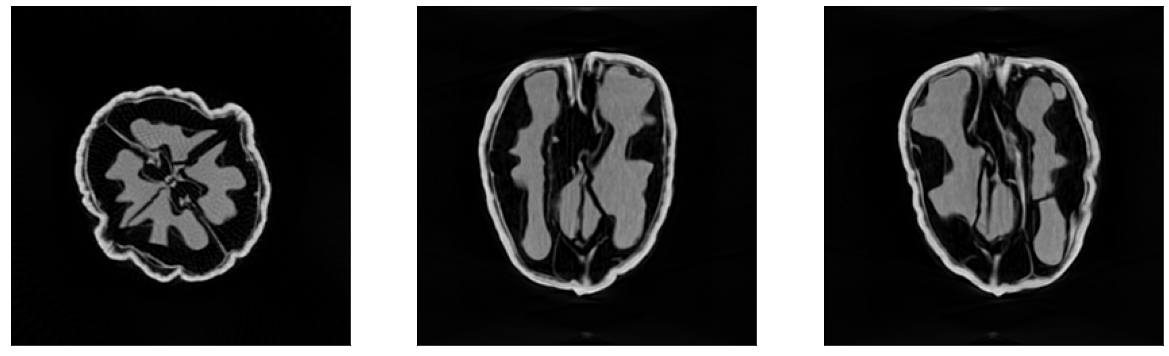

In [5]:
iter_net.eval()
iter_net.inv_module_eval()

start = time.time()
output_test, loss_test = iter_net(test_data, test_images, pt_op_test, pt_op_adj_test)
rec = output_test.detach().cpu().numpy()[0,0]
print("Time: ", time.time() - start)

show(rec)
print("MSE: ", fom.mean_squared_error(rec, x_test[0,0]))
print("PSNR: ", fom.psnr(rec, x_test[0,0]))
print("SSIM: ", fom.ssim(rec, x_test[0,0]))
plot3D(rec, "iLPD")

In [7]:
np.save("result.npy", rec)